In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

chargingprofile1 = pd.read_csv('./data/yearly_charging_profile_1.csv', header=None)
chargingprofile1 = chargingprofile1.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile1.index = range(1, len(chargingprofile1) + 1)
chargingprofile1 = min_max_normalize(chargingprofile1)
chargingprofile_time_series = chargingprofile1

chargingprofile2 = pd.read_csv('./data/yearly_charging_profile_2.csv', header=None)
chargingprofile2 = chargingprofile2.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile2.index = range(1, len(chargingprofile2) + 1)
chargingprofile2 = min_max_normalize(chargingprofile2)

chargingprofile3 = pd.read_csv('./data/yearly_charging_profile_3.csv', header=None)
chargingprofile3 = chargingprofile3.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile3.index = range(1, len(chargingprofile3) + 1)
chargingprofile3 = min_max_normalize(chargingprofile3)

consumer1 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad861.csv', header=None)
consumer1 = consumer1*4
consumer1.columns = range(1, consumer1.shape[1] + 1)
consumer1.index = range(1, len(consumer1) + 1)

consumer2 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad464.csv', header=None)
consumer2 = consumer2*4
consumer2.columns = range(1, consumer2.shape[1] + 1)
consumer2.index = range(1, len(consumer2) + 1)

consumer3 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad540.csv', header=None)
consumer3 = consumer3*4
consumer3.columns = range(1, consumer3.shape[1] + 1)
consumer3.index = range(1, len(consumer3) + 1)

consumer4 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad1029.csv', header=None)
consumer4 = consumer4*4
consumer4.columns = range(1, consumer4.shape[1] + 1)
consumer4.index = range(1, len(consumer4) + 1)

solargen = pd.read_excel('./data/Belgium_solar_generation_probability_density.xlsx', sheet_name='Solar_profiles',header=None)
solargen = solargen
solargen = solargen.drop(index=0, columns=0).reset_index(drop=True)
solargen.index = range(1, len(solargen) + 1)
solargen = solargen.iloc[:, :-1]
solargen_time_series = solargen

Per day: 96x365 => 1x365

In [34]:
# TIMESERIES

from openpyxl import Workbook, load_workbook
workbook = Workbook()  # Create a new workbook
sheet = workbook.active

consumer_profiles = [consumer1, consumer2, consumer3]
rows = ['min', 'max', '', 'yearly_load', '', 'mean', 'std', 'var', 'skew', 'kurt']
kwp_values = [1, 5, 10]
kw_values = [2.5, 7, 11, 23]

results = pd.DataFrame()

for kwp in kwp_values:
    for kw in kw_values:
        data_for_combo = []  # Temporary storage for each combination
        for i, consumer_profile in enumerate(consumer_profiles):
            net_load = consumer_profile - (kwp*solargen_time_series) + (kw * chargingprofile_time_series)
            # Collect metrics
            consumer_results = [
                round(net_load.min().min(), 2),
                round(net_load.max().max(), 2),
                '',  # Placeholder row
                round((net_load / 4).values.sum(), 2),
                '',  # Placeholder row
                round(net_load.mean().mean(), 2),
                round(net_load.std().mean(), 2),
                round(net_load.var().mean(), 2),
                round(net_load.skew().mean(), 2),
                round(net_load.kurt().mean(), 2)
            ]
            data_for_combo.append(consumer_results)


            # print("consumer", i+1,",", kw, "kw: min, max, yearly load")
            # print(round(net_load.min().min(),2))
            # print(round(net_load.max().max(),2))
            # print(round((net_load/4).values.sum(),2))

            # print("consumer", i+1,",",kw, "kw : mean, std, var, skew, kurt")
            # print(round(net_load.mean().mean(),2))
            # print(round(net_load.std().mean(),2))
            # print(round(net_load.var().mean(),2))
            # print(round(net_load.skew().mean(),2))
            # print(round(net_load.kurt().mean(),2))


        # Add the data for each kw to the results DataFrame
        results = pd.concat(
            [results, pd.DataFrame(data_for_combo).T],
            axis=1
        )
            
# Set the appropriate column headers
columns = [
    f"Consumer {i+1}, {kwp} kwp, {charger_kw} charger kw"
    for kwp in kwp_values
    for charger_kw in kw_values
    for i in range(len(consumer_profiles))
]
results.columns = columns

# Set the row index
results.index = rows

# Save the results to an Excel file
results.to_excel("time_series.xlsx")


        

In [35]:
# First difference on columns

from openpyxl import Workbook, load_workbook
workbook = Workbook()  # Create a new workbook
sheet = workbook.active

consumer_profiles = [consumer1, consumer2, consumer3]
rows = ['min', 'max', 'mean', 'std', 'var', 'skew', 'kurt']
kwp_values = [1, 5, 10]
kw_values = [2.5, 7, 11, 23]

results = pd.DataFrame()

for kwp in kwp_values:
    for kw in kw_values:
        data_for_combo = []  # Temporary storage for each combination
        for i, consumer_profile in enumerate(consumer_profiles):
            net_load = consumer_profile - (kwp*solargen_time_series) + (kw * chargingprofile_time_series)
            net_load = net_load.diff().iloc[1:]

            # Collect metrics
            consumer_results = [
                round(net_load.min().min(), 2),
                round(net_load.max().max(), 2),
                round(net_load.abs().mean().mean(), 2),
                round(net_load.std().mean(), 2),
                round(net_load.var().mean(), 2),
                round(net_load.skew().mean(), 2),
                round(net_load.kurt().mean(), 2)
            ]
            data_for_combo.append(consumer_results)


            # print("consumer", i+1,",", kw, "kw: min, max, yearly load")
            # print(round(net_load.min().min(),2))
            # print(round(net_load.max().max(),2))
            # print(round((net_load/4).values.sum(),2))

            # print("consumer", i+1,",",kw, "kw : mean, std, var, skew, kurt")
            # print(round(net_load.mean().mean(),2))
            # print(round(net_load.std().mean(),2))
            # print(round(net_load.var().mean(),2))
            # print(round(net_load.skew().mean(),2))
            # print(round(net_load.kurt().mean(),2))


        # Add the data for each kw to the results DataFrame
        results = pd.concat(
            [results, pd.DataFrame(data_for_combo).T],
            axis=1
        )
            
# Set the appropriate column headers
columns = [
    f"Consumer {i+1}, {kwp} kwp, {charger_kw} charger kw"
    for kwp in kwp_values
    for charger_kw in kw_values
    for i in range(len(consumer_profiles))
]
results.columns = columns

# Set the row index
results.index = rows

# Save the results to an Excel file
results.to_excel("first_difference.xlsx")


        

Statistical moments

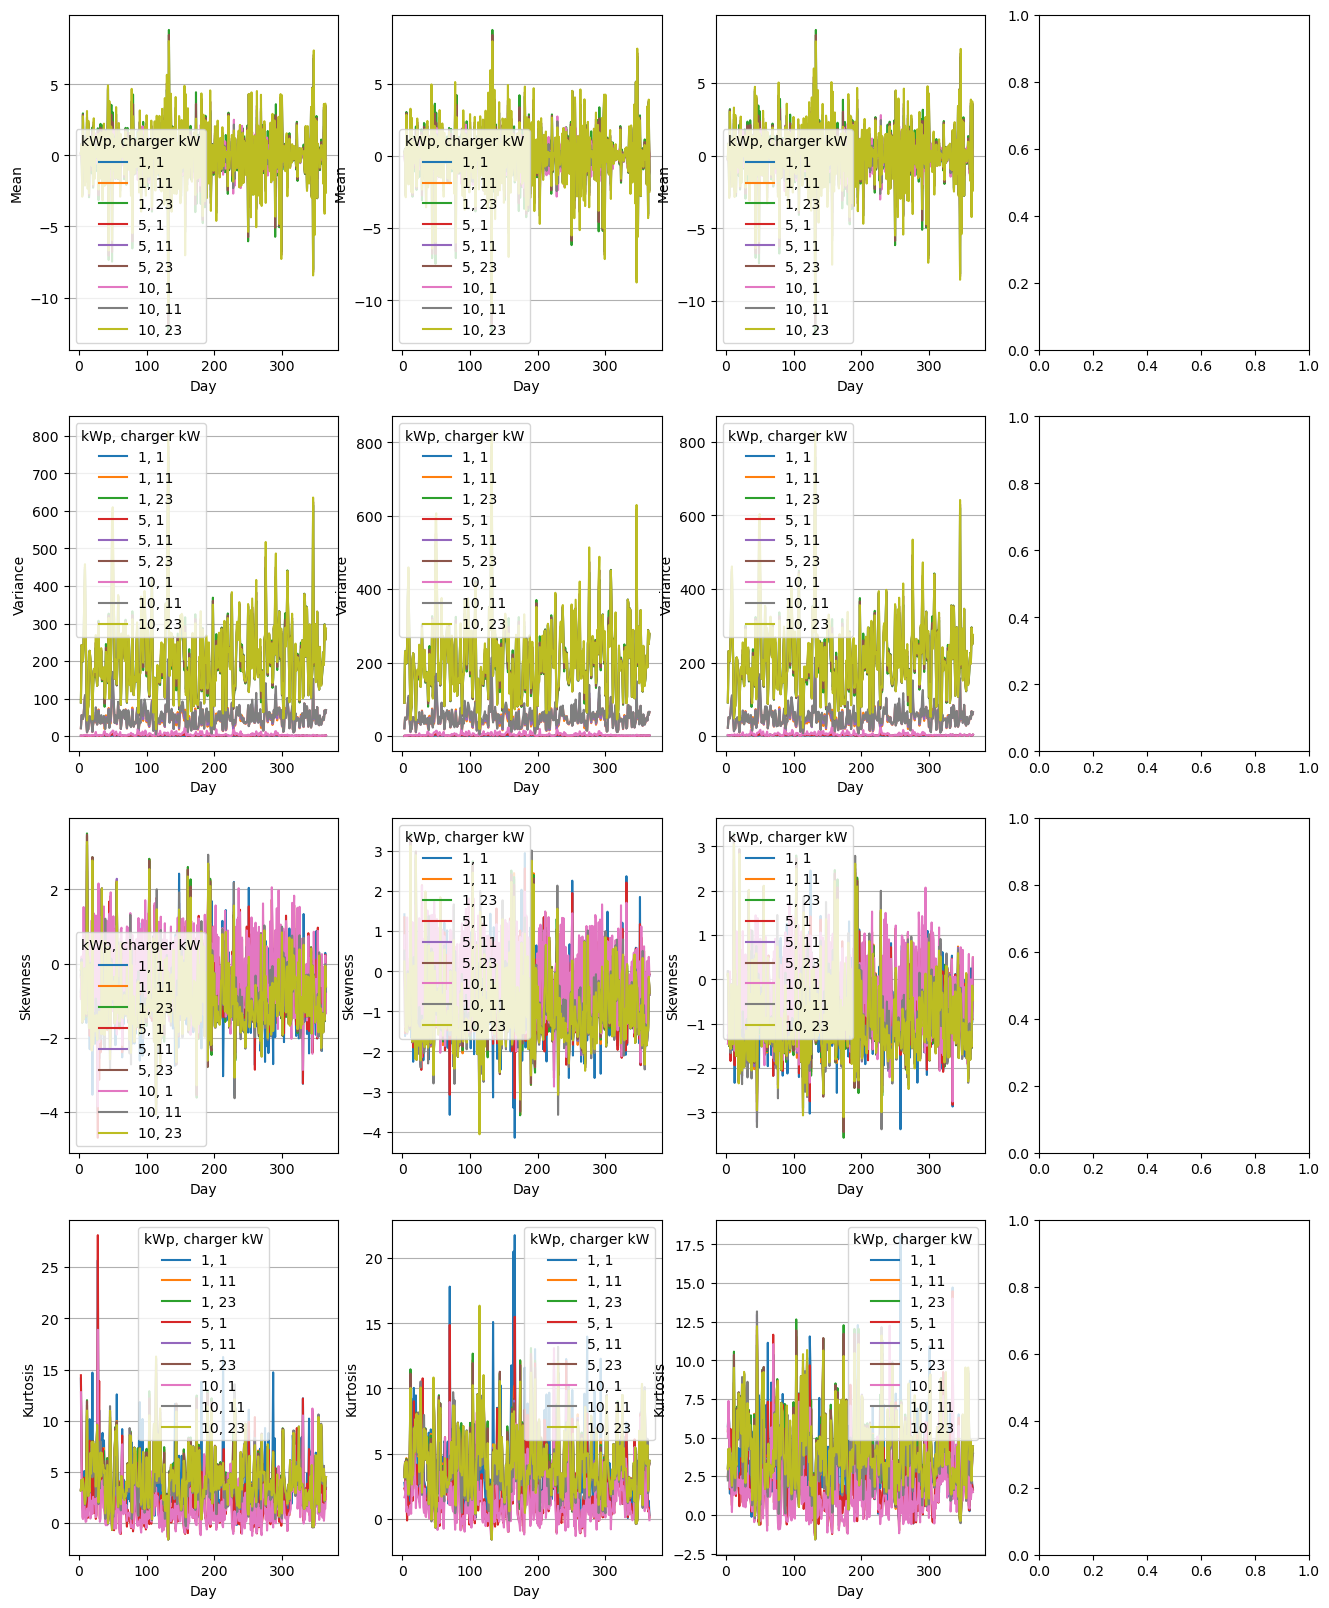

<Figure size 1000x600 with 0 Axes>

In [36]:
kwp_values = [1, 5, 10]
kw_values = [1, 11, 23]

first_difference = 0
second_difference = 1
chargingprofile = chargingprofile1

# consumer_profiles = [consumer1, consumer2, consumer3, consumer4]
consumer_profiles = [consumer1, consumer2, consumer3]

results_mean = {0: [], 1: [], 2: []}
results_var = {0: [], 1: [], 2: []}
results_skew = {0: [], 1: [], 2: []}
results_kurt = {0: [], 1: [], 2: []}

for i, consumer_profile in enumerate(consumer_profiles):
    for kwp in kwp_values: 
        for kw in kw_values:
            net_consumption = consumer_profile + (kw * chargingprofile) - (kwp * solargen)
            # First difference
            if first_difference == 1:
                #net_consumption = net_consumption.diff().iloc[1:]
                net_consumption = net_consumption.diff(axis=1).drop(net_consumption.columns[0], axis=1)

            if second_difference == 1:
                #net_consumption = net_consumption.diff().iloc[1:].diff().iloc[1:]
                net_consumption = net_consumption.diff(axis=1).diff(axis=1).drop(net_consumption.columns[0:2], axis=1)


            net_consumption_mean = net_consumption.mean(axis=0)
            net_consumption_var = net_consumption.var(axis=0)
            net_consumption_skew = net_consumption.skew(axis=0)
            net_consumption_kurt = net_consumption.kurt(axis=0)

            results_mean[i].append(net_consumption_mean)
            results_var[i].append(net_consumption_var)
            results_skew[i].append(net_consumption_skew)
            results_kurt[i].append(net_consumption_kurt)

results_dicts = [results_mean, results_var, results_skew, results_kurt]
titles = ["Mean", "Variance", "Skewness", "Kurtosis"]

fig, axs = plt.subplots(4, 4, figsize=(16, 20))
plt.figure(figsize=(10, 6))

# Plot mean
for consumer in results_mean:
    for i in range(len(results_mean[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[0,consumer].plot(results_mean[consumer][i], label = f'{kwp}, {kw}')
    axs[0,consumer].set_xlabel('Day')
    axs[0,consumer].set_ylabel('Mean')
    axs[0,consumer].legend(title='kWp, charger kW')
    axs[0,consumer].grid(axis='y')

# Plot var
for consumer in results_var:
    for i in range(len(results_var[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[1,consumer].plot(results_var[consumer][i], label = f'{kwp}, {kw}')
    axs[1,consumer].set_xlabel('Day')
    axs[1,consumer].set_ylabel('Variance')
    axs[1,consumer].legend(title='kWp, charger kW')
    axs[1,consumer].grid(axis='y')

# Plot skew
for consumer in results_skew:
    for i in range(len(results_skew[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[2,consumer].plot(results_skew[consumer][i], label = f'{kwp}, {kw}')
    axs[2,consumer].set_xlabel('Day')
    axs[2,consumer].set_ylabel('Skewness')
    axs[2,consumer].legend(title='kWp, charger kW')
    axs[2,consumer].grid(axis='y')

# Plot kurt
for consumer in results_kurt:
    for i in range(len(results_kurt[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[3,consumer].plot(results_kurt[consumer][i], label = f'{kwp}, {kw}')
    axs[3,consumer].set_xlabel('Day')
    axs[3,consumer].set_ylabel('Kurtosis')
    axs[3,consumer].legend(title='kWp, charger kW')
    axs[3,consumer].grid(axis='y')


In [37]:
# Initialize a dictionary for each row with the statistical names as keys
data = {
    "Mean of the Mean": [],
    "Mean of the Variance": [],
    "Mean of the Skewness": [],
    "Mean of the Kurtosis": []
}

# Generate column labels based on consumer and configuration
column_labels = [
    f"consumer {consumer+1} for {kwp} kWp and {kw} charger kW"
    for kwp in [1, 10]
    for kw in [1, 23]
    for consumer in range(3)
]

# Fill in the data for each statistic in the appropriate row of the DataFrame
# Using similar looping logic to calculate means as in your original code
for i in range(len(results_mean[consumer])):
    kwp, kw = None, None  # Set defaults
    for consumer in results_mean:
        # Determine kWp and kw based on the index i and other logic
        if i // 3 == 0:
            kwp = 1
            if i % 3 == 0:
                kw = 1
            elif i % 3 == 2:
                kw = 23
        elif i // 3 == 2:
            kwp = 10
            if i % 3 == 0:
                kw = 1
            elif i % 3 == 2:
                kw = 23
                
        # Append to 'data' only if kwp and kw were assigned values in the above conditions
        if kwp is not None and kw is not None:
            data["Mean of the Mean"].append(round(results_mean[consumer][i].mean(), 2))
            data["Mean of the Variance"].append(round(results_var[consumer][i].mean(), 2))
            data["Mean of the Skewness"].append(round(results_skew[consumer][i].mean(), 2))
            data["Mean of the Kurtosis"].append(round(results_kurt[consumer][i].mean(), 2))

print(data["Mean of the Mean"])
# Create a DataFrame using the filled 'data' dictionary and 'column_labels'
df = pd.DataFrame(data, index=column_labels).T

# Output to an Excel file
#df.to_excel("output.xlsx")


[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [38]:
# Mean of the statistical moments
print('MEAN')
for consumer in results_mean:
    for i in range(len(results_mean[consumer])):
        net_mean_mean = results_mean[consumer][i].mean()
        if i//3 == 0:
            kwp = 1
            if i%3 == 0:
                kw = 1
                print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_mean, 2))
            if i%3 == 2:
                kw = 23
                print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_mean, 2))
        if i//3 == 2:
            kwp = 10
            if i%3 == 0:
                kw = 1
                print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_mean, 2))
            if i%3 == 2:
                kw = 23
                print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_mean, 2))
    print('\n')

print('VARIANCE')
for consumer in results_var:
    for i in range(len(results_var[consumer])):
        net_mean_var = results_var[consumer][i].mean()
        if i//3 == 0:
            kwp = 1
            if i%3 == 0:
                kw = 1
                print('var consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_var, 2))
            if i%3 == 2:
                kw = 23
                print('var consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_var, 2))
        if i//3 == 2:
            kwp = 10
            if i%3 == 0:
                kw = 1
                print('var consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_var, 2))
            if i%3 == 2:
                kw = 23
                print('var consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_var, 2))
    print('\n')

print('SKEWNESS')
for consumer in results_skew:
    for i in range(len(results_skew[consumer])):
        net_mean_skew = results_skew[consumer][i].mean()
        if i//3 == 0:
            kwp = 1
            if i%3 == 0:
                kw = 1
                print('skew consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_skew, 2))
            if i%3 == 2:
                kw = 23
                print('skew consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_skew, 2))
        if i//3 == 2:
            kwp = 10
            if i%3 == 0:
                kw = 1
                print('skew consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_skew, 2))
            if i%3 == 2:
                kw = 23
                print('skew consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_skew, 2))
    print('\n')

print('KURTOSIS')
for consumer in results_kurt:
    for i in range(len(results_kurt[consumer])):
        net_mean_kurt = results_kurt[consumer][i].mean()
        if i//3 == 0:
            kwp = 1
            if i%3 == 0:
                kw = 1
                print('kurt consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_kurt, 2))
            if i%3 == 2:
                kw = 23
                print('kurt consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_kurt, 2))
        if i//3 == 2:
            kwp = 10
            if i%3 == 0:
                kw = 1
                print('kurt consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_kurt, 2))
            if i%3 == 2:
                kw = 23
                print('kurt consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_kurt, 2))
    print('\n')
# for consumer in results_kurt:
#     for i in range(len(results_kurt[consumer])):
#         if i//3 == 0:
#             kwp = 1
#         elif i//3 == 1:
#             kwp = 5
#         elif i//3 == 2:
#             kwp = 10
#         if i%3 == 0:
#              kw = 1 
#         if i%3 == 1:
#              kw = 11  
#         if i%3 == 2:
#              kw = 23    
#         net_mean_kurt = results_kurt[consumer][i].mean()
#         print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_mean, 2))
#     print('\n')

MEAN
Mean consumer 1  for  1  kWp and  1 charger kW:  0.0
Mean consumer 1  for  1  kWp and  23 charger kW:  -0.0
Mean consumer 1  for  10  kWp and  1 charger kW:  -0.0
Mean consumer 1  for  10  kWp and  23 charger kW:  -0.0


Mean consumer 2  for  1  kWp and  1 charger kW:  0.0
Mean consumer 2  for  1  kWp and  23 charger kW:  -0.0
Mean consumer 2  for  10  kWp and  1 charger kW:  -0.0
Mean consumer 2  for  10  kWp and  23 charger kW:  -0.0


Mean consumer 3  for  1  kWp and  1 charger kW:  0.0
Mean consumer 3  for  1  kWp and  23 charger kW:  -0.0
Mean consumer 3  for  10  kWp and  1 charger kW:  -0.0
Mean consumer 3  for  10  kWp and  23 charger kW:  -0.0


VARIANCE
var consumer 1  for  1  kWp and  1 charger kW:  0.81
var consumer 1  for  1  kWp and  23 charger kW:  206.17
var consumer 1  for  10  kWp and  1 charger kW:  4.02
var consumer 1  for  10  kWp and  23 charger kW:  210.91


var consumer 2  for  1  kWp and  1 charger kW:  0.96
var consumer 2  for  1  kWp and  23 charger kW: 

Per quarter hour: 96x365 => 96x1

In [39]:
def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

chargingprofile1 = pd.read_csv('./data/yearly_charging_profile_1.csv', header=None)
chargingprofile1 = chargingprofile1.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile1.index = range(1, len(chargingprofile1) + 1)
chargingprofile1 = min_max_normalize(chargingprofile1)

chargingprofile2 = pd.read_csv('./data/yearly_charging_profile_2.csv', header=None)
chargingprofile2 = chargingprofile2.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile2.index = range(1, len(chargingprofile2) + 1)
chargingprofile2 = min_max_normalize(chargingprofile2)

chargingprofile3 = pd.read_csv('./data/yearly_charging_profile_3.csv', header=None)
chargingprofile3 = chargingprofile3.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile3.index = range(1, len(chargingprofile3) + 1)
chargingprofile3 = min_max_normalize(chargingprofile3)

consumer1 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad861.csv', header=None)
consumer1 = consumer1*4
consumer1.columns = range(1, consumer1.shape[1] + 1)
consumer1.index = range(1, len(consumer1) + 1)

consumer2 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad464.csv', header=None)
consumer2 = consumer2*4
consumer2.columns = range(1, consumer2.shape[1] + 1)
consumer2.index = range(1, len(consumer2) + 1)

consumer3 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad540.csv', header=None)
consumer3 = consumer3*4
consumer3.columns = range(1, consumer3.shape[1] + 1)
consumer3.index = range(1, len(consumer3) + 1)

consumer4 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad1029.csv', header=None)
consumer4 = consumer4*4
consumer4.columns = range(1, consumer4.shape[1] + 1)
consumer4.index = range(1, len(consumer4) + 1)

solargen = pd.read_excel('./data/Belgium_solar_generation_probability_density.xlsx', sheet_name='Solar_profiles',header=None)
solargen = solargen
solargen = solargen.drop(index=0, columns=0).reset_index(drop=True)
solargen.index = range(1, len(solargen) + 1)
solargen = solargen.iloc[:, :-1]

In [40]:
# TIMESERIES

from openpyxl import Workbook, load_workbook
workbook = Workbook()  # Create a new workbook
sheet = workbook.active

consumer_profiles = [consumer1, consumer2, consumer3]
rows = ['min', 'max', '', 'yearly_load', '', 'mean', 'std', 'var', 'skew', 'kurt']
kwp_values = [1, 5, 10]
kw_values = [2.5, 7, 11, 23]

results = pd.DataFrame()

for kwp in kwp_values:
    for kw in kw_values:
        data_for_combo = []  # Temporary storage for each combination
        for i, consumer_profile in enumerate(consumer_profiles):
            net_load = consumer_profile - (kwp*solargen_time_series) + (kw * chargingprofile_time_series)
            # Collect metrics
            consumer_results = [
                round(net_load.min().min(), 2),
                round(net_load.max().max(), 2),
                '',  # Placeholder row
                round((net_load / 4).values.sum(), 2),
                '',  # Placeholder row
                round(net_load.mean(axis=1).mean(), 2),
                round(net_load.std(axis=1).mean(), 2),
                round(net_load.var(axis=1).mean(), 2),
                round(net_load.skew(axis=1).mean(), 2),
                round(net_load.kurt(axis=1).mean(), 2)
            ]
            data_for_combo.append(consumer_results)


            # print("consumer", i+1,",", kw, "kw: min, max, yearly load")
            # print(round(net_load.min().min(),2))
            # print(round(net_load.max().max(),2))
            # print(round((net_load/4).values.sum(),2))

            # print("consumer", i+1,",",kw, "kw : mean, std, var, skew, kurt")
            # print(round(net_load.mean().mean(),2))
            # print(round(net_load.std().mean(),2))
            # print(round(net_load.var().mean(),2))
            # print(round(net_load.skew().mean(),2))
            # print(round(net_load.kurt().mean(),2))


        # Add the data for each kw to the results DataFrame
        results = pd.concat(
            [results, pd.DataFrame(data_for_combo).T],
            axis=1
        )
            
# Set the appropriate column headers
columns = [
    f"Consumer {i+1}, {kwp} kwp, {charger_kw} charger kw"
    for kwp in kwp_values
    for charger_kw in kw_values
    for i in range(len(consumer_profiles))
]
results.columns = columns

# Set the row index
results.index = rows

# Save the results to an Excel file
results.to_excel("time_series.xlsx")


        

In [41]:
# First difference on rows

from openpyxl import Workbook, load_workbook
workbook = Workbook()  # Create a new workbook
sheet = workbook.active

consumer_profiles = [consumer1, consumer2, consumer3]
rows = ['min', 'max', 'mean', 'std', 'var', 'skew', 'kurt']
kwp_values = [1, 5, 10]
kw_values = [2.5, 7, 11, 23]

results = pd.DataFrame()

for kwp in kwp_values:
    for kw in kw_values:
        data_for_combo = []  # Temporary storage for each combination
        for i, consumer_profile in enumerate(consumer_profiles):
            net_load = consumer_profile - (kwp*solargen_time_series) + (kw * chargingprofile_time_series)
            net_load = net_load.diff(axis=1).drop(net_load.columns[0], axis=1)

            # Collect metrics
            consumer_results = [
                round(net_load.min().min(), 2),
                round(net_load.max().max(), 2),
                round(net_load.abs().mean(axis=1).mean(), 2),
                round(net_load.std(axis=1).mean(), 2),
                round(net_load.var(axis=1).mean(), 2),
                round(net_load.skew(axis=1).mean(), 2),
                round(net_load.kurt(axis=1).mean(), 2)
            ]
            data_for_combo.append(consumer_results)


            # print("consumer", i+1,",", kw, "kw: min, max, yearly load")
            # print(round(net_load.min().min(),2))
            # print(round(net_load.max().max(),2))
            # print(round((net_load/4).values.sum(),2))

            # print("consumer", i+1,",",kw, "kw : mean, std, var, skew, kurt")
            # print(round(net_load.mean().mean(),2))
            # print(round(net_load.std().mean(),2))
            # print(round(net_load.var().mean(),2))
            # print(round(net_load.skew().mean(),2))
            # print(round(net_load.kurt().mean(),2))


        # Add the data for each kw to the results DataFrame
        results = pd.concat(
            [results, pd.DataFrame(data_for_combo).T],
            axis=1
        )
            
# Set the appropriate column headers
columns = [
    f"Consumer {i+1}, {kwp} kwp, {charger_kw} charger kw"
    for kwp in kwp_values
    for charger_kw in kw_values
    for i in range(len(consumer_profiles))
]
results.columns = columns

# Set the row index
results.index = rows

# Save the results to an Excel file
results.to_excel("first_difference.xlsx")

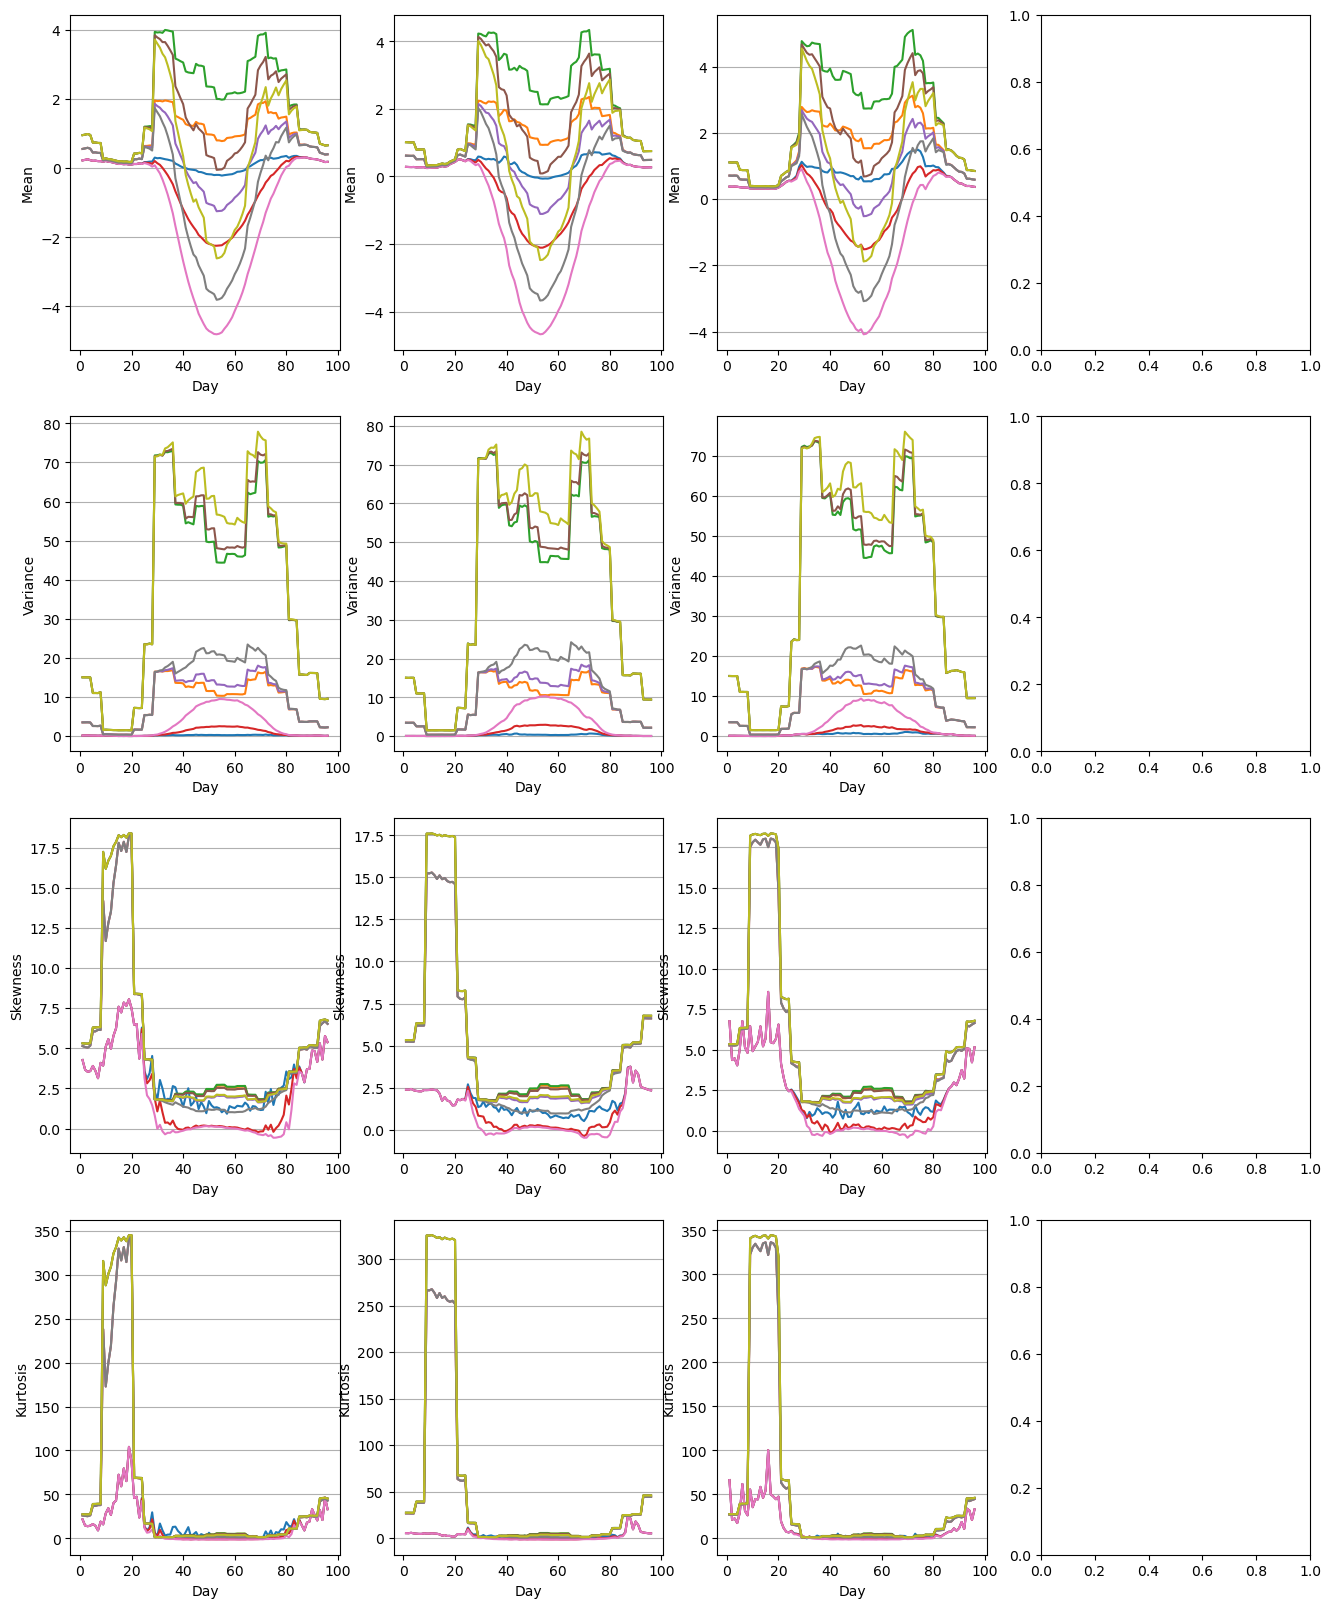

<Figure size 1000x600 with 0 Axes>

In [42]:
kwp_values = [1, 5, 10]
kw_values = [1, 11, 23]

first_difference = 0
second_difference = 0
chargingprofile = chargingprofile1

# consumer_profiles = [consumer1, consumer2, consumer3, consumer4]
consumer_profiles = [consumer1, consumer2, consumer3]

results_mean = {0: [], 1: [], 2: []}
results_var = {0: [], 1: [], 2: []}
results_skew = {0: [], 1: [], 2: []}
results_kurt = {0: [], 1: [], 2: []}

for i, consumer_profile in enumerate(consumer_profiles):
    for kwp in kwp_values: 
        for kw in kw_values:
            net_consumption = consumer_profile + (kw * chargingprofile) - (kwp * solargen)
            # First difference
            if first_difference == 1:
                #net_consumption = net_consumption.diff(axis=1).drop(net_consumption.columns[0], axis=1)
                net_consumption = net_consumption.diff().iloc[1:]

            if second_difference == 1:
                #net_consumption = net_consumption.diff(axis=1).diff(axis=1).drop(net_consumption.columns[0:2], axis=1)
                net_consumption = net_consumption.diff().iloc[1:].diff().iloc[1:]

            net_consumption_mean = net_consumption.mean(axis=1)
            net_consumption_var = net_consumption.var(axis=1)
            net_consumption_skew = net_consumption.skew(axis=1)
            net_consumption_kurt = net_consumption.kurt(axis=1)

            results_mean[i].append(net_consumption_mean)
            results_var[i].append(net_consumption_var)
            results_skew[i].append(net_consumption_skew)
            results_kurt[i].append(net_consumption_kurt)

results_dicts = [results_mean, results_var, results_skew, results_kurt]
titles = ["Mean", "Variance", "Skewness", "Kurtosis"]

fig, axs = plt.subplots(4, 4, figsize=(16, 20))
plt.figure(figsize=(10, 6))

# Plot mean
for consumer in results_mean:
    for i in range(len(results_mean[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[0,consumer].plot(results_mean[consumer][i], label = f'{kwp}, {kw}')
    axs[0,consumer].set_xlabel('Day')
    axs[0,consumer].set_ylabel('Mean')
    #axs[0,consumer].legend(title='kWp, charger kW')
    axs[0,consumer].grid(axis='y')

# Plot var
for consumer in results_var:
    for i in range(len(results_var[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[1,consumer].plot(results_var[consumer][i], label = f'{kwp}, {kw}')
    axs[1,consumer].set_xlabel('Day')
    axs[1,consumer].set_ylabel('Variance')
    #axs[1,consumer].legend(title='kWp, charger kW')
    axs[1,consumer].grid(axis='y')

# Plot skew
for consumer in results_skew:
    for i in range(len(results_skew[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[2,consumer].plot(results_skew[consumer][i], label = f'{kwp}, {kw}')
    axs[2,consumer].set_xlabel('Day')
    axs[2,consumer].set_ylabel('Skewness')
    #axs[2,consumer].legend(title='kWp, charger kW')
    axs[2,consumer].grid(axis='y')

# Plot kurt
for consumer in results_kurt:
    for i in range(len(results_kurt[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
             kw = 1 
        if i%3 == 1:
             kw = 11  
        if i%3 == 2:
             kw = 23             
        axs[3,consumer].plot(results_kurt[consumer][i], label = f'{kwp}, {kw}')
    axs[3,consumer].set_xlabel('Day')
    axs[3,consumer].set_ylabel('Kurtosis')
    #axs[3,consumer].legend(title='kWp, charger kW')
    axs[3,consumer].grid(axis='y')


In [43]:
# Initialize a dictionary for each row with the statistical names as keys
data = {
    "Mean of the Mean": [],
    "Mean of the Variance": [],
    "Mean of the Skewness": [],
    "Mean of the Kurtosis": []
}

# Generate column labels based on consumer and configuration
column_labels = [
    f"consumer {consumer+1} for {kwp} kWp and {kw} charger kW"
    for kwp in [1, 10]
    for kw in [1, 23]
    for consumer in range(3)
]

# Fill in the data for each statistic in the appropriate row of the DataFrame
# Using similar looping logic to calculate means as in your original code
for i in range(len(results_mean[consumer])):
    kwp, kw = None, None  # Set defaults
    for consumer in results_mean:
        # Determine kWp and kw based on the index i and other logic
        if i // 3 == 0:
            kwp = 1
            if i % 3 == 0:
                kw = 1
            elif i % 3 == 2:
                kw = 23
        elif i // 3 == 2:
            kwp = 10
            if i % 3 == 0:
                kw = 1
            elif i % 3 == 2:
                kw = 23
                
        # Append to 'data' only if kwp and kw were assigned values in the above conditions
        if kwp is not None and kw is not None:
            data["Mean of the Mean"].append(round(results_mean[consumer][i].mean(), 2))
            data["Mean of the Variance"].append(round(results_var[consumer][i].mean(), 2))
            data["Mean of the Skewness"].append(round(results_skew[consumer][i].mean(), 2))
            data["Mean of the Kurtosis"].append(round(results_kurt[consumer][i].mean(), 2))

print(data["Mean of the Mean"])
# Create a DataFrame using the filled 'data' dictionary and 'column_labels'
df = pd.DataFrame(data, index=column_labels).T

# Output to an Excel file
df.to_excel("output.xlsx")


[0.13, 0.34, 0.71, 1.97, 2.18, 2.55, -1.32, -1.1, -0.74, 0.52, 0.74, 1.1]


In [44]:
# Mean of the statistical moments
print('MEAN')
for consumer in results_mean:
    for i in range(len(results_mean[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
            kw = 1 
        if i%3 == 1:
            kw = 11  
        if i%3 == 2:
            kw = 23    
        net_mean_mean = results_mean[consumer][i].mean()
        print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_mean, 2))
    print('\n')

print('VARIANCE')
for consumer in results_var:
    for i in range(len(results_var[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
            kw = 1 
        if i%3 == 1:
            kw = 11  
        if i%3 == 2:
            kw = 23    
        net_mean_var = results_var[consumer][i].mean()
        print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_var, 2))
    print('\n')

print('SKEWNESS')
for consumer in results_skew:
    for i in range(len(results_skew[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
            kw = 1 
        if i%3 == 1:
            kw = 11  
        if i%3 == 2:
            kw = 23    
        net_mean_skew = results_skew[consumer][i].mean()
        print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_skew, 2))
    print('\n')

print('KURTOSIS')
for consumer in results_kurt:
    for i in range(len(results_kurt[consumer])):
        if i//3 == 0:
            kwp = 1
        elif i//3 == 1:
            kwp = 5
        elif i//3 == 2:
            kwp = 10
        if i%3 == 0:
            kw = 1 
        if i%3 == 1:
            kw = 11  
        if i%3 == 2:
            kw = 23    
        net_mean_kurt = results_kurt[consumer][i].mean()
        print('Mean consumer',consumer+1, ' for ', kwp,' kWp and ', kw, 'charger kW: ', round(net_mean_kurt, 2))
    print('\n')

MEAN
Mean consumer 1  for  1  kWp and  1 charger kW:  0.13
Mean consumer 1  for  1  kWp and  11 charger kW:  0.96
Mean consumer 1  for  1  kWp and  23 charger kW:  1.97
Mean consumer 1  for  5  kWp and  1 charger kW:  -0.51
Mean consumer 1  for  5  kWp and  11 charger kW:  0.32
Mean consumer 1  for  5  kWp and  23 charger kW:  1.32
Mean consumer 1  for  10  kWp and  1 charger kW:  -1.32
Mean consumer 1  for  10  kWp and  11 charger kW:  -0.48
Mean consumer 1  for  10  kWp and  23 charger kW:  0.52


Mean consumer 2  for  1  kWp and  1 charger kW:  0.34
Mean consumer 2  for  1  kWp and  11 charger kW:  1.18
Mean consumer 2  for  1  kWp and  23 charger kW:  2.18
Mean consumer 2  for  5  kWp and  1 charger kW:  -0.3
Mean consumer 2  for  5  kWp and  11 charger kW:  0.54
Mean consumer 2  for  5  kWp and  23 charger kW:  1.54
Mean consumer 2  for  10  kWp and  1 charger kW:  -1.1
Mean consumer 2  for  10  kWp and  11 charger kW:  -0.27
Mean consumer 2  for  10  kWp and  23 charger kW:  0.74